In [1]:
# https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
np.__version__

'1.15.4'

In [4]:
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast

In [5]:
from catboost import CatBoostClassifier
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook

In [6]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../data/train.csv.zip')
test = pd.read_csv('../data/test.csv.zip')
train.shape, test.shape

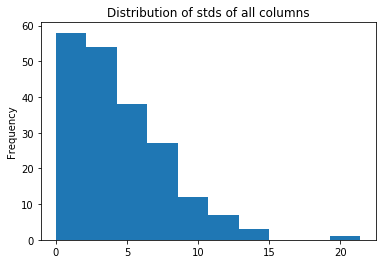

In [8]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

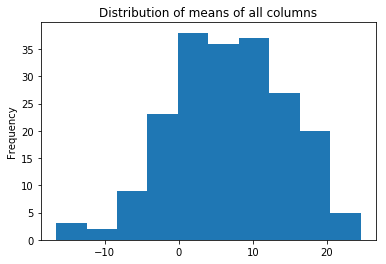

In [9]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

Distributions of first 28 columns


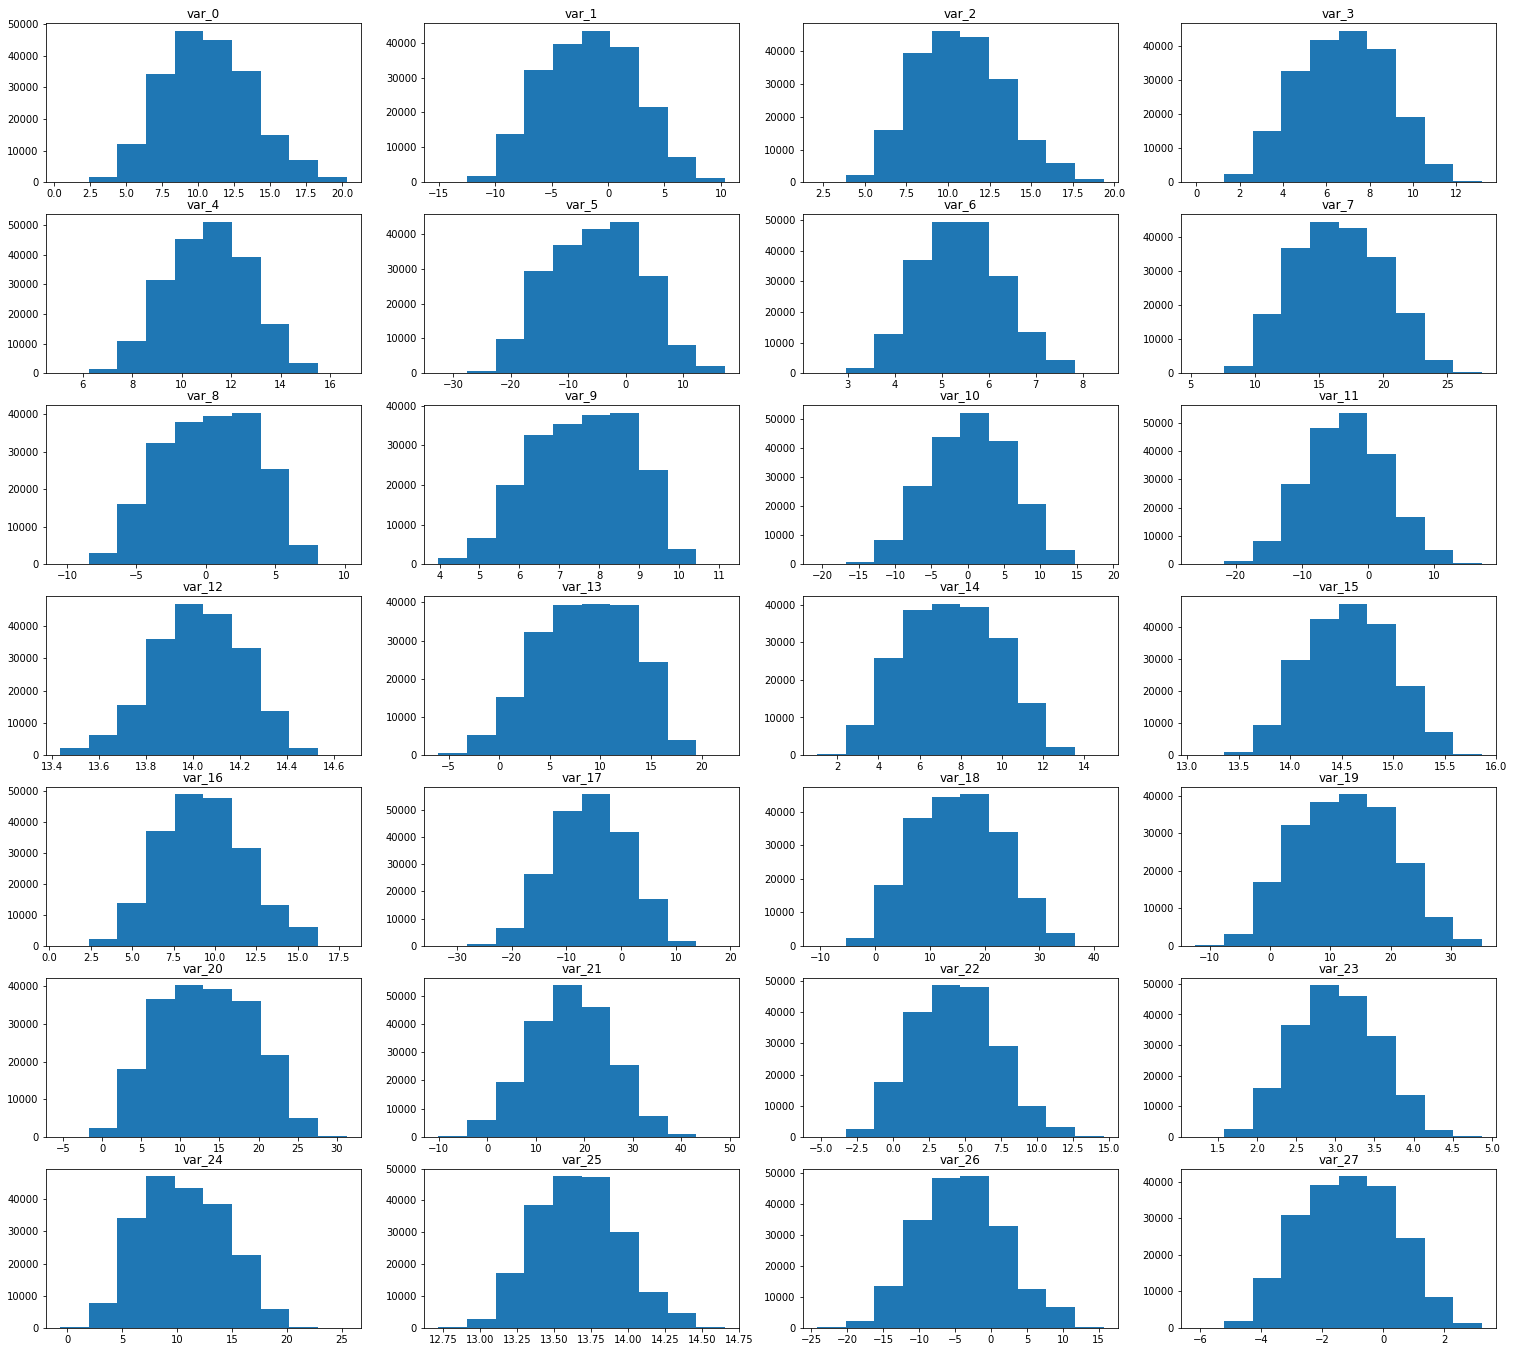

In [10]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

Distributions of first 28 columns


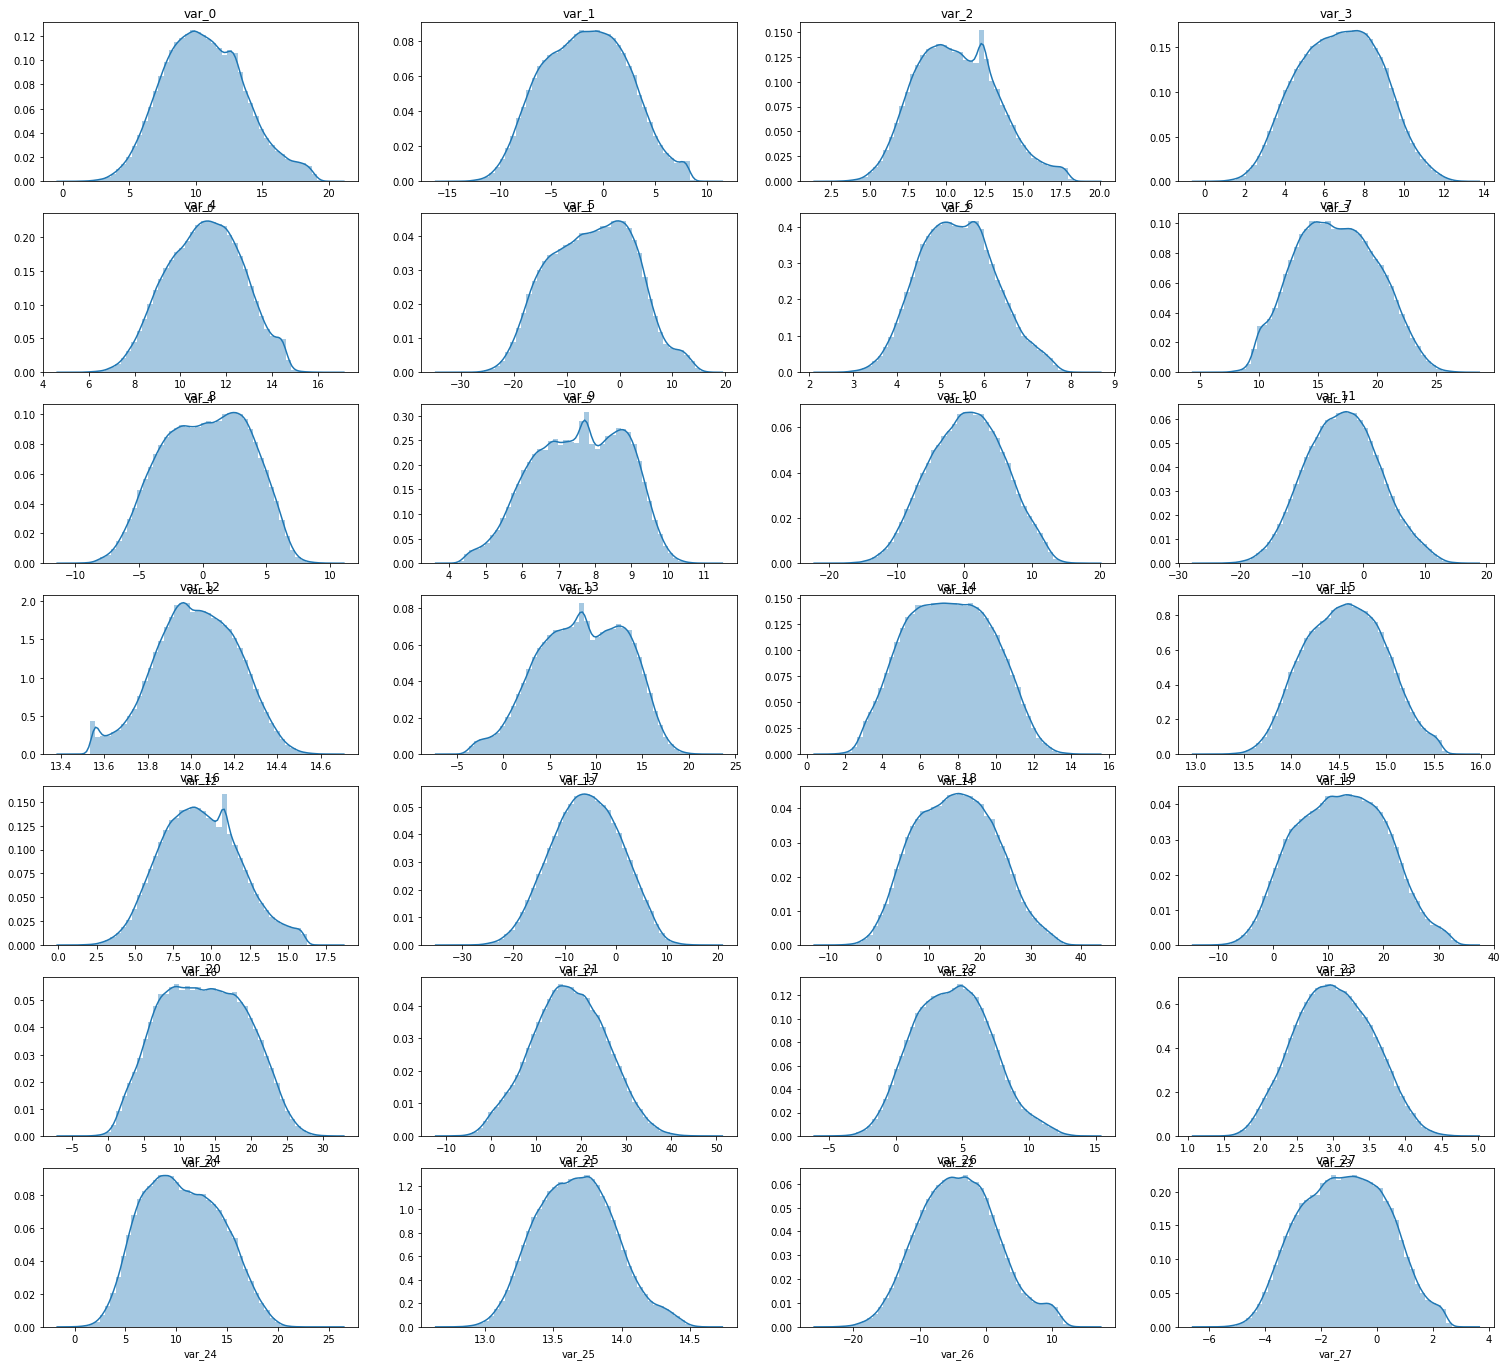

In [11]:
import seaborn as sns
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    sns.distplot(train[col])
    plt.title(col)

In [12]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

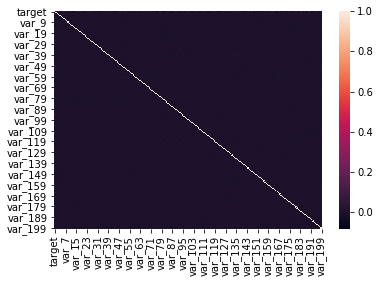

In [13]:
# sns.heatmap(train.corr())

In [ ]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [15]:
# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score, roc_auc_score, mean_absolute_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which 
# the objective has been evaluated are less than delta

In [39]:
from time import time
import pprint
import joblib

# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [40]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
#                          class_weight='balanced',
                         objective='binary',
                         random_state= 42,
                         bagging_seed = 11,
                         verbosity= -1,
                         n_jobs=-1, 
                         verbose=0)

search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 500),
        'min_child_samples': Integer(0, 200),
        'max_bin': Integer(100, 100000),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'subsample_freq': Integer(0, 10),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'min_child_weight': Integer(0, 10),
        'subsample_for_bin': Integer(100000, 500000),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform'),
        'n_estimators': Integer(10, 10000)        
        }

search_spaces = {
    'num_leaves': Integer(2, 500),
    'min_data_in_leaf': Integer(0, 200),
    'max_depth': Integer(0, 500),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'bagging_freq': Integer(0, 10),
    'feature_fraction': Real(0.01, 1.0, 'uniform'),
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
    'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'min_gain_to_split': Real(0.01, 1.0, 'uniform'),
    'min_child_weight': Integer(0, 30)
}


opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring='roc_auc',
                    cv=folds,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y,'LightGBM', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

LightGBM took 317.50 seconds,  candidates checked: 2, best CV score: 0.873 ± 0.003
Best parameters:
{'bagging_freq': 2,
 'feature_fraction': 0.25739435264644617,
 'learning_rate': 0.2102710733412174,
 'max_depth': 356,
 'min_child_weight': 29,
 'min_data_in_leaf': 40,
 'min_gain_to_split': 0.9391189944320584,
 'num_leaves': 106,
 'reg_alpha': 0.00047706111368021073,
 'reg_lambda': 0.012045158797759246,
 'subsample': 0.6875572440338598}



In [ ]:
from time import ctime
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', ctime())
#         X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        if model_type == 'xgb':
#             print('1')
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)
#             print('2')
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#             print('2a')
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             print('3')
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
#         if model_type == 'lgb':
#             # feature importance
#             fold_importance = pd.DataFrame()
#             fold_importance["feature"] = X.columns
#             fold_importance["importance"] = model.feature_importance()
#             fold_importance["fold"] = fold_n + 1
#             feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores


In [16]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures()
X1 = pd.concat([X,X_test], axis=0)
print(X1.shape)
X1 = p.fit_transform(X1)
X = X1[:len(X)]
X_test = X1[len(X):]

(400000, 200)


In [17]:
X.shape, X_test.shape

((200000, 20301), (200000, 20301))

In [21]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 20}
# params = {
#     'colsample_bytree': 0.3706219857878677,
#     'learning_rate': 0.16624226726409647,
#     'max_bin': 93400,
#     'max_depth': 134,
#     'min_child_samples': 22,
#     'min_child_weight': 4,
#     'n_estimators': 8028,
#     'num_leaves': 27,
#     'reg_alpha': 1.081049236893711e-05,
#     'reg_lambda': 1.043686239159047,
#     'scale_pos_weight': 0.19222548462579486,
#     'subsample': 0.6941640075502717,
#     'subsample_for_bin': 375140,
#     'subsample_freq': 7,
#     'metric': 'auc',
#     'num_threads': 4,
#     'random_state':42
# }

# params = {
#     'colsample_bytree': 0.3706219857878677,
#     'learning_rate': 0.16624226726409647,
#     'max_bin': 93400,
#     'max_depth': 134,
#     'min_child_samples': 22,
#     'min_child_weight': 4,
#     'n_estimators': 8028,
#     'num_leaves': 27,
#     'reg_alpha': 1.081049236893711e-05,
#     'reg_lambda': 1.043686239159047,
#     'scale_pos_weight': 0.19222548462579486,
#     'subsample': 0.81,
#     'subsample_for_bin': 375140,
#     'subsample_freq': 7,
#     'min_gain_to_split': 0.01077313523861969,
#     'min_child_weight': 19.428902804238373,
#     'metric': 'auc',
#     'num_threads': 4,
#     'random_state':42
# }

# Fold 0 started at Sun Feb 24 03:43:14 2019
# Training until validation scores don't improve for 200 rounds.
# [1000]	training's auc: 0.899201	valid_1's auc: 0.870296
# [2000]	training's auc: 0.921084	valid_1's auc: 0.885213
# [3000]	training's auc: 0.931213	valid_1's auc: 0.890596
# [4000]	training's auc: 0.93818	valid_1's auc: 0.892833
# [5000]	training's auc: 0.944842	valid_1's auc: 0.893549
# [6000]	training's auc: 0.951367	valid_1's auc: 0.893868
# Early stopping, best iteration is:
# [6312]	training's auc: 0.953304	valid_1's auc: 0.893931

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Sun Feb 24 13:09:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899201	valid_1's auc: 0.870296
[2000]	training's auc: 0.921084	valid_1's auc: 0.885213
[3000]	training's auc: 0.931213	valid_1's auc: 0.890596
[4000]	training's auc: 0.93818	valid_1's auc: 0.892833
[5000]	training's auc: 0.944842	valid_1's auc: 0.893549
[6000]	training's auc: 0.951367	valid_1's auc: 0.893868
Early stopping, best iteration is:
[6312]	training's auc: 0.953304	valid_1's auc: 0.893931
Fold 1 started at Sun Feb 24 18:19:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899377	valid_1's auc: 0.869779
[2000]	training's auc: 0.920661	valid_1's auc: 0.885129
[3000]	training's auc: 0.930618	valid_1's auc: 0.891113
[4000]	training's auc: 0.937727	valid_1's auc: 0.893393
[5000]	training's auc: 0.94439	valid_1's auc: 0.894181
[6000]	training's auc: 0.950744	valid_1's auc: 0.894552
Early stopping, best iterat

KeyboardInterrupt: 

In [23]:
train['var_0'].describe()

count    200000.000000
mean         10.679914
std           3.040051
min           0.408400
25%           8.453850
50%          10.524750
75%          12.758200
max          20.315000
Name: var_0, dtype: float64

Fold 0 started at Tue Feb 19 15:24:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885014	valid_1's auc: 0.864492
[2000]	training's auc: 0.909721	valid_1's auc: 0.882867
[3000]	training's auc: 0.921202	valid_1's auc: 0.89042
[4000]	training's auc: 0.928088	valid_1's auc: 0.89445
[5000]	training's auc: 0.932895	valid_1's auc: 0.896647
[6000]	training's auc: 0.936977	valid_1's auc: 0.897681
[7000]	training's auc: 0.940894	valid_1's auc: 0.898105
[8000]	training's auc: 0.944607	valid_1's auc: 0.898296
Early stopping, best iteration is:
[8530]	training's auc: 0.946556	valid_1's auc: 0.898392
Fold 1 started at Tue Feb 19 15:31:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884713	valid_1's auc: 0.864687
[2000]	training's auc: 0.90936	valid_1's auc: 0.883356
[3000]	training's auc: 0.921266	valid_1's auc: 0.891113
[4000]	training's auc: 0.928168	valid_1's auc: 0.895326
[5000]	training's auc: 0.932

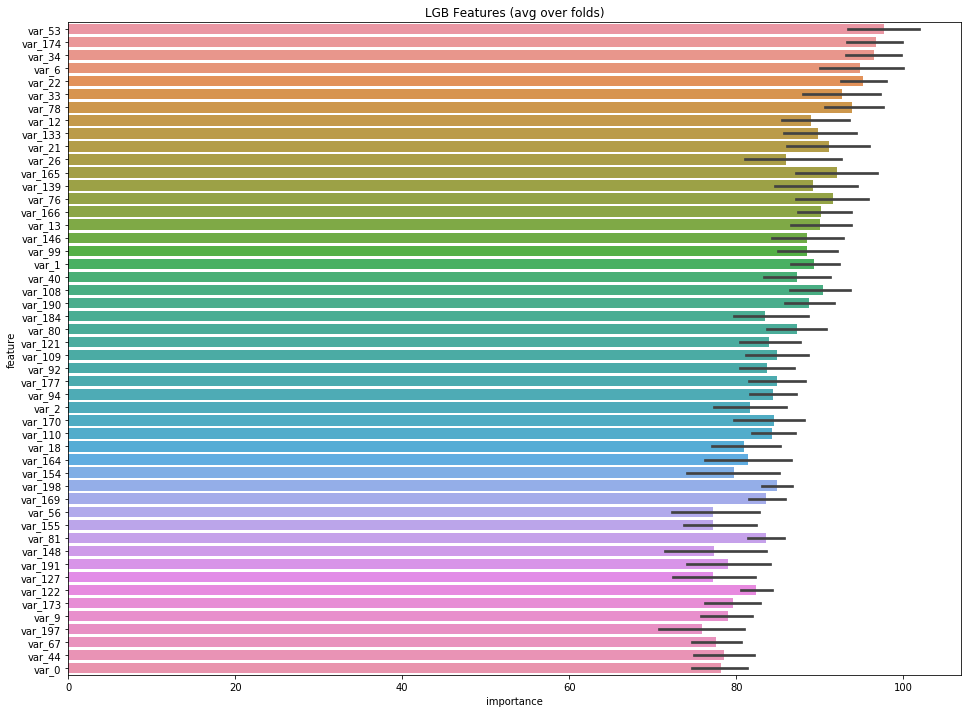

In [41]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

params = {
    'colsample_bytree': 0.3706219857878677,
    'learning_rate': 0.16624226726409647,
    'max_bin': 93400,
    'max_depth': 134,
    'min_child_samples': 22,
    'min_child_weight': 4,
    'n_estimators': 8028,
    'num_leaves': 27,
    'reg_alpha': 1.081049236893711e-05,
    'reg_lambda': 1.043686239159047,
    'scale_pos_weight': 0.19222548462579486,
    'subsample': 0.6941640075502717,
    'subsample_for_bin': 375140,
    'subsample_freq': 7,
}

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [19]:
np.save('../cache/oof_lgb', oof_lgb)
np.save('../cache/prediction_lgb', prediction_lgb)
np.save('../cache/scores', scores)

In [27]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub1a.csv', index=False)

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../submissions/sub1a.csv -m " "

In [ ]:
!kaggle competitions submissions -c santander-customer-transaction-prediction

Fold 0 started at Tue Feb 19 13:21:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866485	valid_1's auc: 0.84906
[2000]	training's auc: 0.895269	valid_1's auc: 0.872443
[3000]	training's auc: 0.908978	valid_1's auc: 0.882687
[4000]	training's auc: 0.91745	valid_1's auc: 0.888379
[5000]	training's auc: 0.92327	valid_1's auc: 0.892014
[6000]	training's auc: 0.927657	valid_1's auc: 0.894364
[7000]	training's auc: 0.93108	valid_1's auc: 0.896081
[8000]	training's auc: 0.933934	valid_1's auc: 0.897067
[9000]	training's auc: 0.936585	valid_1's auc: 0.897746
[10000]	training's auc: 0.939144	valid_1's auc: 0.898183
[11000]	training's auc: 0.941678	valid_1's auc: 0.898428
Early stopping, best iteration is:
[10897]	training's auc: 0.941448	valid_1's auc: 0.898463
Fold 1 started at Tue Feb 19 13:30:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866744	valid_1's auc: 0.849655
[2000]	training's auc: 0.8

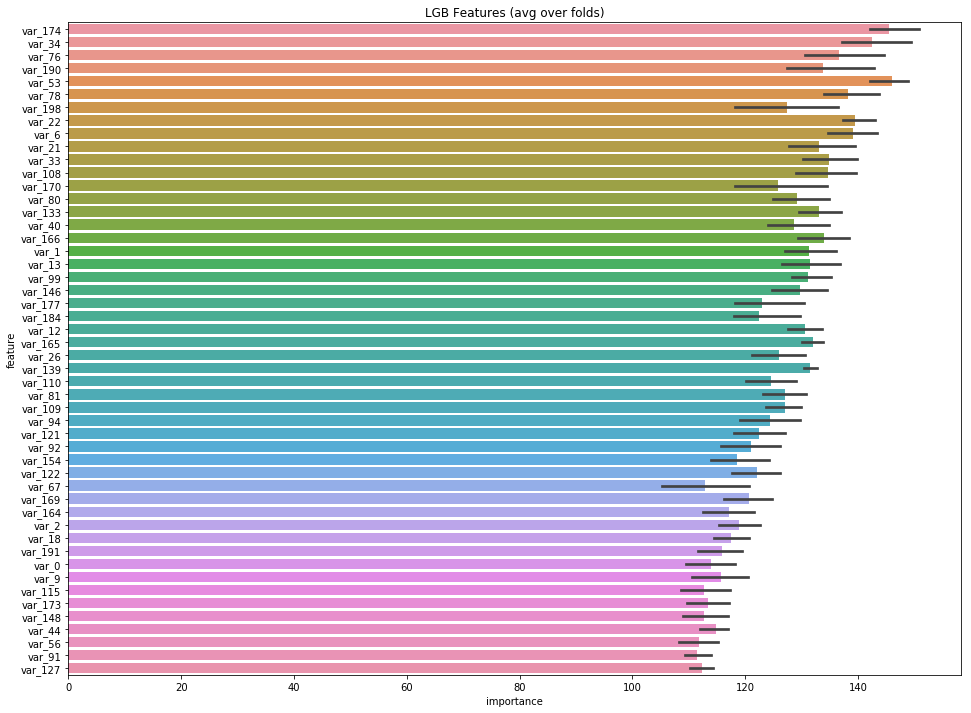

In [23]:
best = {'bagging_freq': 14, 'feature_fraction': 0.6645452259093495, 'learning_rate': 0.9104709179139949, 'max_depth': 18, 
        'min_child_weight': 0.1936027500260209, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.3165755403433436, 
        'num_leaves': 1788, 'reg_alpha': 0.1962993164404836, 'metric': 'auc', 'boosting': 'gbdt',
         'verbosity': -1,
        'reg_lambda': 0.12729980022303397, 'subsample': 0.6191170180441716}
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.008,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb1, prediction_lgb1, scores1 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [24]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb1
sub.to_csv('../submissions/sub1b.csv', index=False)

In [21]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [42]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884796	valid_1's auc: 0.863996
[2000]	training's auc: 0.909754	valid_1's auc: 0.883341
[3000]	training's auc: 0.921236	valid_1's auc: 0.891485
[4000]	training's auc: 0.928121	valid_1's auc: 0.895495
[5000]	training's auc: 0.932972	valid_1's auc: 0.897463
[6000]	training's auc: 0.936911	valid_1's auc: 0.898596
[7000]	training's auc: 0.94072	valid_1's auc: 0.899005
Early stopping, best iteration is:
[7641]	training's auc: 0.943127	valid_1's auc: 0.899255


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [43]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0254,var_81
0.0215,var_139
0.0195,var_12
0.0176,var_110
0.0167,var_53
0.0158,var_6
0.0155,var_26
0.0153,var_174
0.0150,var_146
0.0148,var_22


In [44]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=120, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0254,var_81
0.0215,var_139
0.0195,var_12
0.0176,var_110
0.0167,var_53
0.0158,var_6
0.0155,var_26
0.0153,var_174
0.0150,var_146
0.0148,var_22


In [45]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883739	valid_1's auc: 0.863615
[2000]	training's auc: 0.904231	valid_1's auc: 0.881132
[3000]	training's auc: 0.912039	valid_1's auc: 0.887247
[4000]	training's auc: 0.916339	valid_1's auc: 0.889774
[5000]	training's auc: 0.919738	valid_1's auc: 0.890673
[6000]	training's auc: 0.923393	valid_1's auc: 0.890992
[7000]	training's auc: 0.927153	valid_1's auc: 0.89109
Early stopping, best iteration is:
[6822]	training's auc: 0.926471	valid_1's auc: 0.891122


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [46]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:110]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884874	valid_1's auc: 0.863816
[2000]	training's auc: 0.905387	valid_1's auc: 0.878726
[3000]	training's auc: 0.913169	valid_1's auc: 0.883672
[4000]	training's auc: 0.917501	valid_1's auc: 0.885457
[5000]	training's auc: 0.920693	valid_1's auc: 0.886076
Early stopping, best iteration is:
[5468]	training's auc: 0.922375	valid_1's auc: 0.886293


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [51]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [52]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:30]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

In [53]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


Fold 0 started at Tue Feb 19 16:17:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884054	valid_1's auc: 0.861962
[2000]	training's auc: 0.909109	valid_1's auc: 0.880804
[3000]	training's auc: 0.9208	valid_1's auc: 0.888573
[4000]	training's auc: 0.928138	valid_1's auc: 0.892489
[5000]	training's auc: 0.933742	valid_1's auc: 0.894392
[6000]	training's auc: 0.939031	valid_1's auc: 0.895506
[7000]	training's auc: 0.944003	valid_1's auc: 0.896052
Early stopping, best iteration is:
[7332]	training's auc: 0.945604	valid_1's auc: 0.896094
Fold 1 started at Tue Feb 19 16:54:14 2019
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [17]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [55]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:10]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

Fold 0 started at Tue Feb 19 16:56:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883658	valid_1's auc: 0.86286
[2000]	training's auc: 0.909206	valid_1's auc: 0.882228
[3000]	training's auc: 0.920836	valid_1's auc: 0.890004
[4000]	training's auc: 0.927904	valid_1's auc: 0.893952
[5000]	training's auc: 0.932834	valid_1's auc: 0.896024
[6000]	training's auc: 0.937139	valid_1's auc: 0.897046
[7000]	training's auc: 0.941286	valid_1's auc: 0.897438
[8000]	training's auc: 0.945246	valid_1's auc: 0.897627
Early stopping, best iteration is:
[8320]	training's auc: 0.946518	valid_1's auc: 0.897761
Fold 1 started at Tue Feb 19 17:06:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883323	valid_1's auc: 0.863649
[2000]	training's auc: 0.908523	valid_1's auc: 0.882941
[3000]	training's auc: 0.920697	valid_1's auc: 0.890695
[4000]	training's auc: 0.927751	valid_1's auc: 0.894752
[5000]	training's auc: 0.9

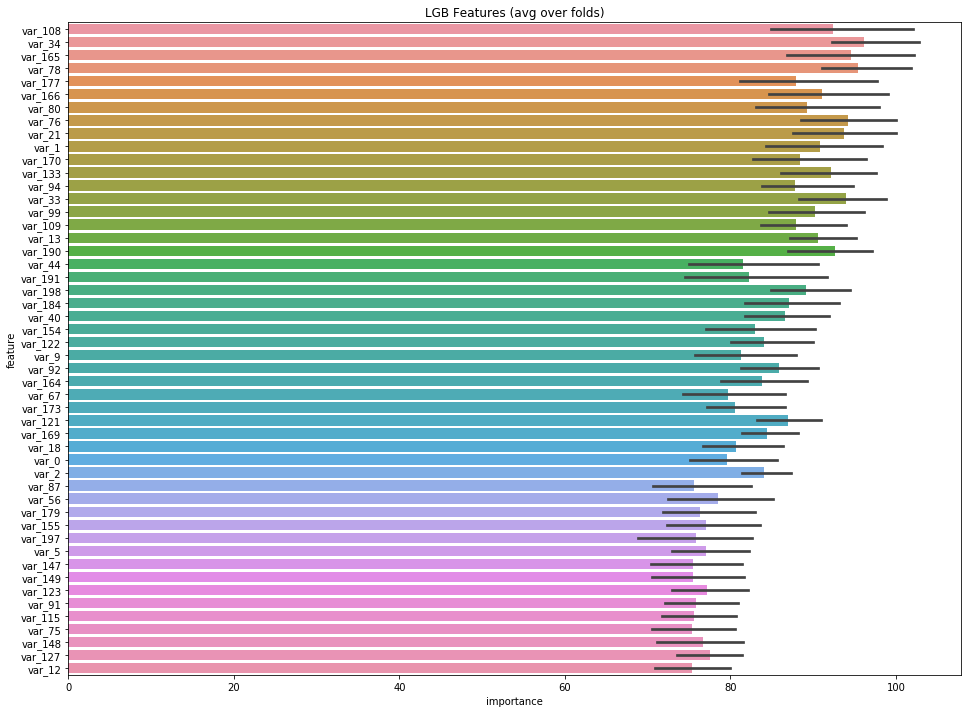

In [56]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


In [57]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb_inter
sub.to_csv('../submissions/sub1c.csv', index=False)

In [16]:

xgb_params = {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, folds=folds, model_type='xgb')

Fold 0 started at Tue Feb 19 18:43:50 2019
[0]	train-auc:0.608758	valid_data-auc:0.601929
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907889	valid_data-auc:0.872789
[1000]	train-auc:0.932237	valid_data-auc:0.887631
[1500]	train-auc:0.943743	valid_data-auc:0.893153
[2000]	train-auc:0.951329	valid_data-auc:0.894989
[2500]	train-auc:0.957301	valid_data-auc:0.895685
Stopping. Best iteration:
[2641]	train-auc:0.958613	valid_data-auc:0.895861

Fold 1 started at Tue Feb 19 19:09:56 2019
[0]	train-auc:0.599652	valid_data-auc:0.592425
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907902	valid_data-auc:0.874244
[1000]	train-auc:0.932342	valid_data-auc:0.889326
[1500]	train-auc:0.943571	valid_data-auc:0.894195
[2000]	train-auc:0.951021	valid_data-

In [17]:
np.save('../cache/oof_xgb', oof_xgb)
np.save('../cache/prediction_xgb', prediction_xgb)
np.save('../cache/scores_xgb', scores)

In [18]:
cat_params = {'depth': 13,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=cat_params, folds=folds, model_type='cat')

Fold 0 started at Tue Feb 19 22:12:22 2019
Fold 1 started at Tue Feb 19 23:40:41 2019
Fold 2 started at Wed Feb 20 00:58:51 2019
Fold 3 started at Wed Feb 20 01:56:55 2019
Fold 4 started at Wed Feb 20 03:01:35 2019
CV mean score: 0.8853, std: 0.0029.


In [19]:
np.save('../cache/oof_cat', oof_cat)
np.save('../cache/prediction_cat', prediction_cat)
# np.save('../cache/scores_xgb', scores)

In [15]:
X = pd.DataFrame()
oof_lgb = np.load('../cache/oof_lgb.npy')
oof_xgb = np.load('../cache/oof_xgb.npy')
oof_cat = np.load('../cache/oof_cat.npy')
X['lgb'] = oof_lgb
X['xgb'] = oof_xgb
X['cat'] = oof_cat

In [16]:
X_test = pd.DataFrame()
prediction_lgb = np.load('../cache/prediction_lgb.npy')
prediction_xgb = np.load('../cache/prediction_xgb.npy')
prediction_cat = np.load('../cache/prediction_cat.npy')
X_test['lgb'] = prediction_lgb
X_test['xgb'] = prediction_xgb
X_test['cat'] = prediction_cat

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5000)
rf.fit(X,y)
preds = rf.predict(X_test)

In [19]:
preds = rf.predict_proba(X_test)[:,1]

In [20]:
preds

array([0.063 , 0.3526, 0.3106, ..., 0.    , 0.1332, 0.1004])

In [21]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1d.csv', index=False)

In [22]:
preds1 = np.clip(preds, 0.05, 0.95)

In [23]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds1
sub.to_csv('../submissions/sub1e.csv', index=False) 

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X,y)
preds = rf.predict(X_test)

In [30]:
preds = rf.predict_proba(X_test)[:,1]


In [31]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1g.csv', index=False) 

In [32]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb)/2
sub.to_csv('../submissions/sub1h.csv', index=False) 

In [33]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb + prediction_cat)/3
sub.to_csv('../submissions/sub1i.csv', index=False) 